In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
     "C:\PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    

(32, 256, 256, 3)
[2 0 0 1 1 1 0 0 1 0 1 0 2 0 0 1 2 2 1 1 0 1 1 1 1 1 0 0 0 2 0 1]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[198. 184. 181.]
  [187. 173. 170.]
  [182. 168. 165.]
  ...
  [166. 147. 149.]
  [168. 149. 151.]
  [173. 154. 156.]]

 [[186. 172. 169.]
  [182. 168. 165.]
  [181. 167. 164.]
  ...
  [165. 146. 148.]
  [167. 148. 150.]
  [171. 152. 154.]]

 [[184. 170. 167.]
  [190. 176. 173.]
  [190. 176. 173.]
  ...
  [166. 147. 149.]
  [167. 148. 150.]
  [169. 150. 152.]]

 ...

 [[144. 116. 115.]
  [121.  93.  92.]
  [132. 104. 103.]
  ...
  [134. 106. 105.]
  [129. 101. 100.]
  [118.  90.  89.]]

 [[140. 112. 111.]
  [109.  81.  80.]
  [133. 105. 104.]
  ...
  [147. 119. 118.]
  [136. 108. 107.]
  [130. 102. 101.]]

 [[163. 135. 134.]
  [123.  95.  94.]
  [143. 115. 114.]
  ...
  [140. 112. 111.]
  [113.  85.  84.]
  [110.  82.  81.]]], shape=(256, 256, 3), dtype=float32)


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[188., 183., 189.],
        [192., 187., 193.],
        [200., 195., 201.],
        ...,
        [177., 174., 181.],
        [181., 178., 185.],
        [185., 182., 189.]],

       [[184., 179., 185.],
        [185., 180., 186.],
        [188., 183., 189.],
        ...,
        [177., 174., 181.],
        [181., 178., 185.],
        [186., 183., 190.]],

       [[188., 183., 189.],
        [186., 181., 187.],
        [185., 180., 186.],
        ...,
        [176., 173., 180.],
        [184., 181., 188.],
        [192., 189., 196.]],

       ...,

       [[148., 143., 149.],
        [156., 151., 157.],
        [177., 172., 178.],
        ...,
        [147., 142., 149.],
        [140., 135., 142.],
        [141., 136., 143.]],

       [[146., 141., 147.],
        [137., 132., 138.],
        [147., 142., 148.],
        ...,
        [164., 159., 166.],
        [150., 145., 152.],
       

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[1].shape)

(256, 256, 3)


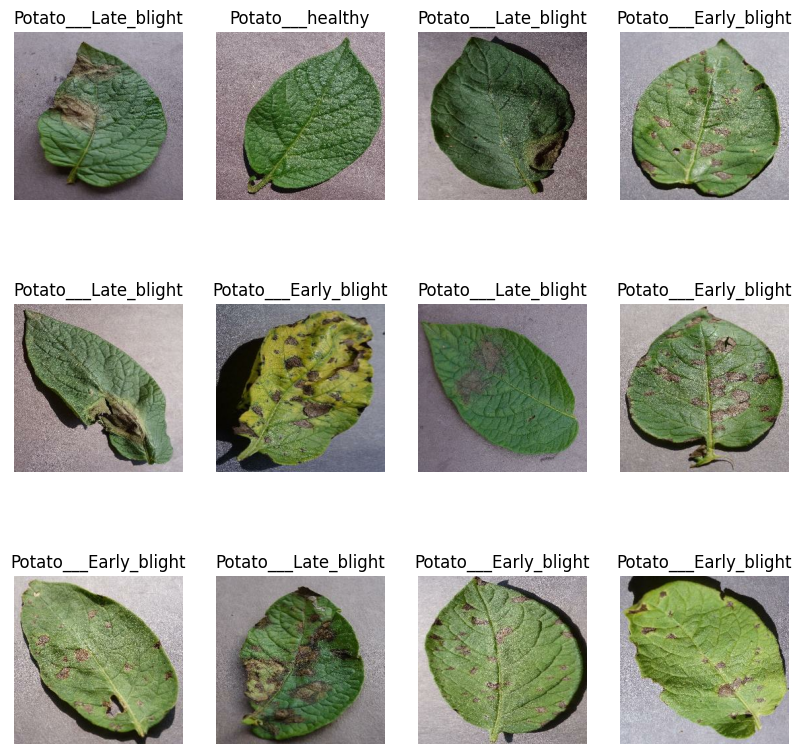

In [10]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

68

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_split + val_split)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
        return train_ds,val_ds,test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(val_ds)

6

In [21]:
len(train_ds)

54

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),])

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='Softmax'),
])
model.build(input_shape=input_shape)


In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50


54/54 [==============================] - 104s 2s/step - loss: 0.8970 - accuracy: 0.4786 - val_loss: 0.8862 - val_accuracy: 0.5365
Epoch 2/50
54/54 [==============================] - 97s 2s/step - loss: 0.6750 - accuracy: 0.7037 - val_loss: 0.4526 - val_accuracy: 0.7917
Epoch 3/50
54/54 [==============================] - 97s 2s/step - loss: 0.4010 - accuracy: 0.8258 - val_loss: 0.1991 - val_accuracy: 0.9219
Epoch 4/50
54/54 [==============================] - 100s 2s/step - loss: 0.3717 - accuracy: 0.8819 - val_loss: 0.5865 - val_accuracy: 0.7760
Epoch 5/50
54/54 [==============================] - 97s 2s/step - loss: 0.4622 - accuracy: 0.8189 - val_loss: 0.4035 - val_accuracy: 0.8229
Epoch 6/50
54/54 [==============================] - 95s 2s/step - loss: 0.3398 - accuracy: 0.8495 - val_loss: 0.4418 - val_accuracy: 0.8594
Epoch 7/50
54/54 [==============================] - 97s 2s/step - loss: 0.2550 - accuracy: 0.9074 - val_loss: 0.2024 - val_accuracy: 0.9010
Epoch 8/50
54/54

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 480ms/step - loss: 0.0317 - accuracy: 0.9766


In [31]:
scores


[0.031681060791015625, 0.9765625]

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.47858795523643494,
 0.7037037014961243,
 0.8258101940155029,
 0.8819444179534912,
 0.8188657164573669,
 0.8495370149612427,
 0.9074074029922485,
 0.9230324029922485,
 0.9519675970077515,
 0.9589120149612427,
 0.9606481194496155,
 0.9641203880310059,
 0.9646990895271301,
 0.9612268805503845,
 0.9716435074806213,
 0.96875,
 0.9739583134651184,
 0.9809027910232544,
 0.9612268805503845,
 0.984375,
 0.9837962985038757,
 0.9837962985038757,
 0.9837962985038757,
 0.9814814925193787,
 0.9809027910232544,
 0.9473379850387573,
 0.9728009104728699,
 0.9855324029922485,
 0.9670138955116272,
 0.9108796119689941,
 0.9785879850387573,
 0.9739583134651184,
 0.9693287014961243,
 0.9809027910232544,
 0.984375,
 0.9861111044883728,
 0.9884259104728699,
 0.9878472089767456,
 0.9803240895271301,
 0.9756944179534912,
 0.9849537014961243,
 0.9878472089767456,
 0.9895833134651184,
 0.9884259104728699,
 0.9924768805503845,
 0.9918981194496155,
 0.9936342835426331,
 0.9907407164573669,
 0.9901620149612427,
 

In [35]:
len(history.history['accuracy'])

50

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

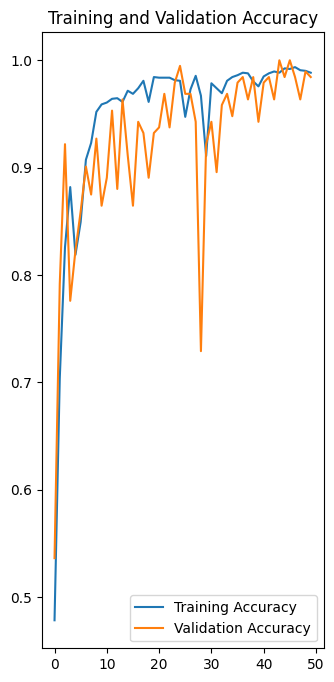

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

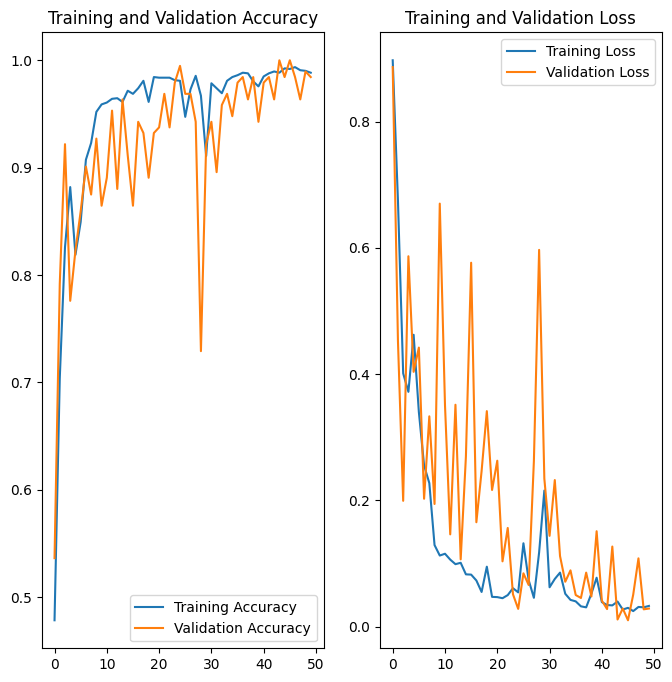

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch[0])

tf.Tensor(
[[[127. 133. 145.]
  [101. 107. 119.]
  [147. 151. 163.]
  ...
  [160. 161. 179.]
  [161. 162. 180.]
  [159. 160. 178.]]

 [[107. 113. 125.]
  [107. 113. 125.]
  [125. 129. 141.]
  ...
  [155. 156. 174.]
  [156. 157. 175.]
  [155. 156. 174.]]

 [[ 99. 103. 115.]
  [104. 108. 120.]
  [ 97. 101. 113.]
  ...
  [154. 155. 173.]
  [154. 155. 173.]
  [154. 155. 173.]]

 ...

 [[113. 114. 132.]
  [132. 133. 151.]
  [147. 148. 166.]
  ...
  [187. 190. 207.]
  [184. 187. 204.]
  [185. 188. 205.]]

 [[119. 120. 138.]
  [152. 153. 171.]
  [118. 119. 137.]
  ...
  [171. 174. 191.]
  [169. 172. 189.]
  [171. 174. 191.]]

 [[137. 138. 156.]
  [146. 147. 165.]
  [139. 140. 158.]
  ...
  [177. 180. 197.]
  [180. 183. 200.]
  [186. 189. 206.]]], shape=(256, 256, 3), dtype=float32)


In [41]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch[0].numpy())

[[[145. 126. 128.]
  [150. 131. 133.]
  [141. 122. 124.]
  ...
  [179. 173. 175.]
  [174. 168. 170.]
  [166. 160. 162.]]

 [[135. 116. 118.]
  [124. 105. 107.]
  [136. 117. 119.]
  ...
  [179. 173. 175.]
  [175. 169. 171.]
  [167. 161. 163.]]

 [[152. 133. 135.]
  [126. 107. 109.]
  [133. 117. 118.]
  ...
  [180. 174. 176.]
  [178. 172. 174.]
  [171. 165. 167.]]

 ...

 [[137. 131. 135.]
  [149. 143. 147.]
  [174. 168. 172.]
  ...
  [193. 187. 189.]
  [191. 185. 187.]
  [186. 180. 182.]]

 [[146. 140. 144.]
  [150. 144. 148.]
  [147. 141. 145.]
  ...
  [194. 188. 190.]
  [193. 187. 189.]
  [188. 182. 184.]]

 [[133. 127. 131.]
  [147. 141. 145.]
  [143. 137. 141.]
  ...
  [197. 191. 193.]
  [199. 193. 195.]
  [195. 189. 191.]]]


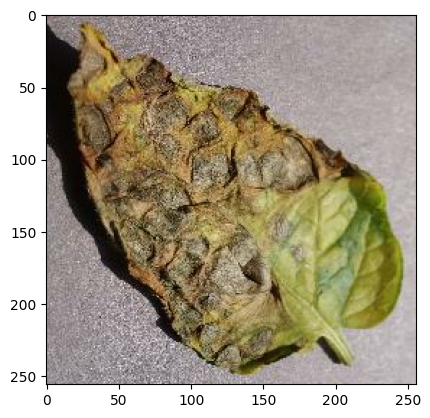

In [44]:
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

In [45]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch[0].numpy().astype('uint8'))

[[[159 156 165]
  [157 154 163]
  [156 153 162]
  ...
  [180 177 184]
  [135 132 139]
  [166 163 170]]

 [[163 160 169]
  [161 158 167]
  [160 157 166]
  ...
  [225 222 229]
  [191 188 195]
  [151 148 155]]

 [[166 163 172]
  [165 162 171]
  [163 160 169]
  ...
  [153 150 157]
  [181 178 185]
  [146 143 150]]

 ...

 [[140 135 139]
  [141 136 140]
  [142 137 141]
  ...
  [137 128 131]
  [140 131 134]
  [140 131 134]]

 [[141 136 140]
  [140 135 139]
  [139 134 138]
  ...
  [125 116 119]
  [126 117 120]
  [128 119 122]]

 [[138 133 137]
  [136 131 135]
  [133 128 132]
  ...
  [118 109 112]
  [124 115 118]
  [134 125 128]]]


In [57]:
np.argmax([1.5458938e-05, 9.9997962e-01, 4.9051223e-06])

1

first image to predict
first image's actual label: Potato___Late_blight
1/1 [==============================] - 1s 515ms/step
[1.5458938e-05 9.9997962e-01 4.9051223e-06]


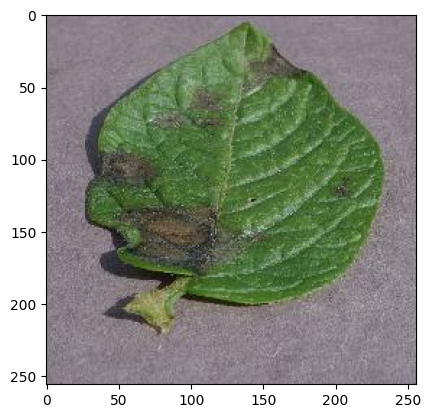

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

batch_prediction = model.predict(images_batch)
print(batch_prediction[0])

first image to predict
first image's actual label: tf.Tensor(0, shape=(), dtype=int32)


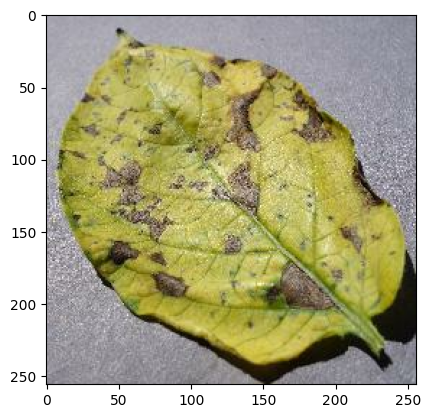

In [59]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", first_label)

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

first image to predict
first image's actual label: Potato___Late_blight


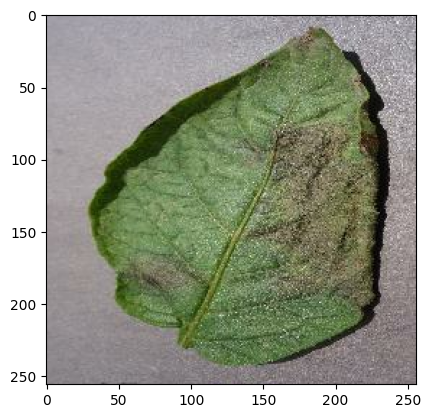

In [61]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

1/1 [==============================] - 0s 63ms/step


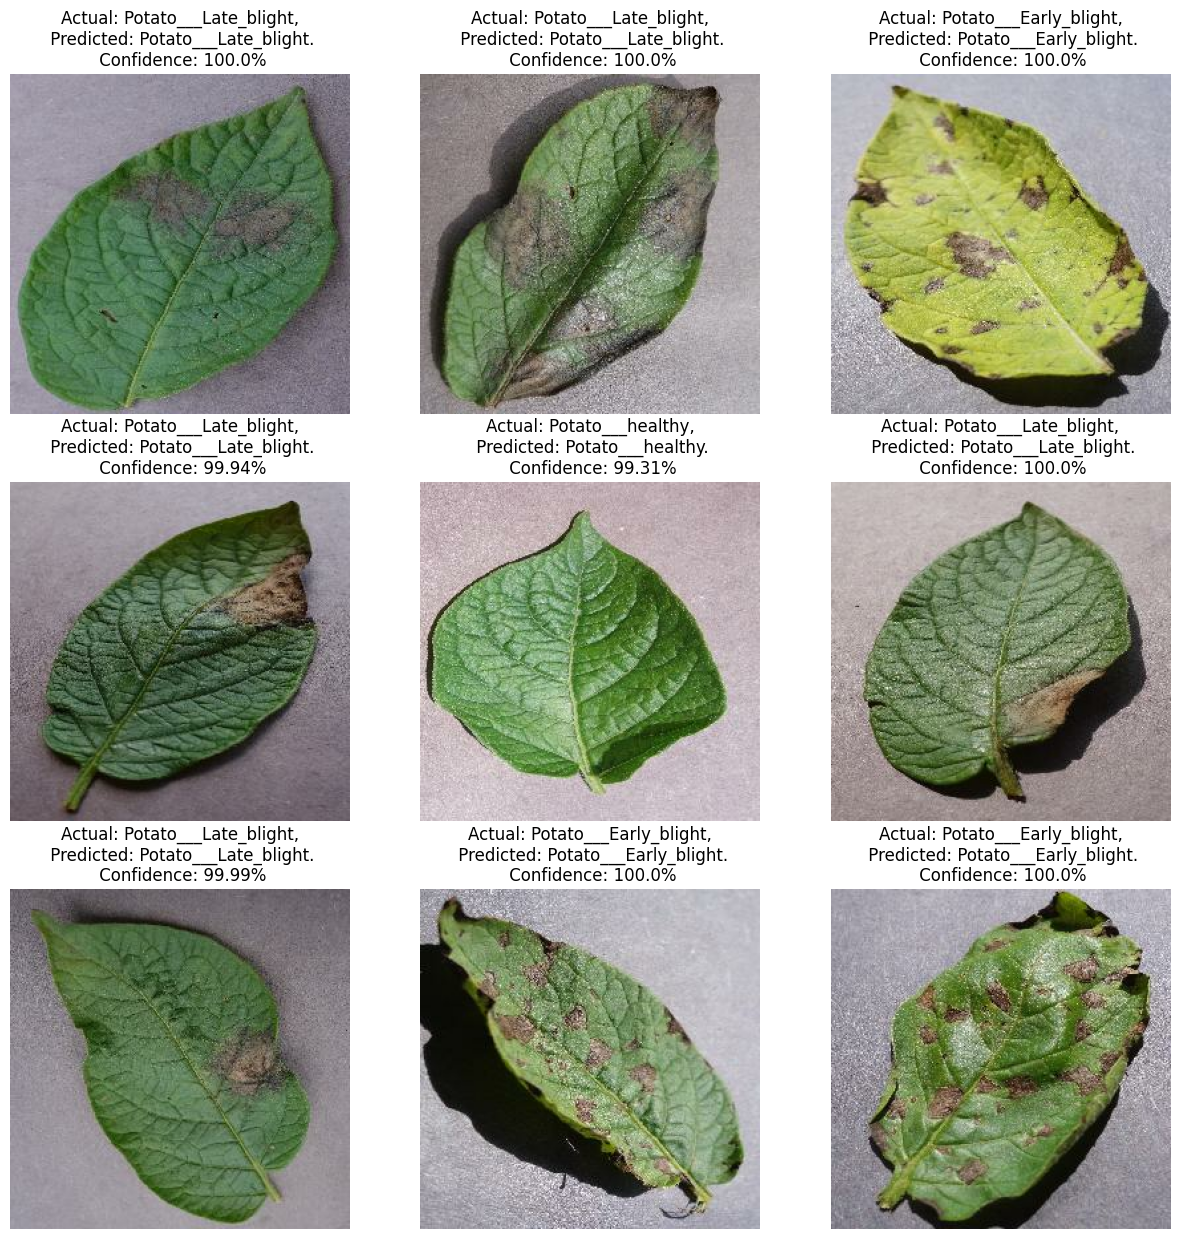

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [63]:
model_version=1
model.save(f"model/{model_version}")

INFO:tensorflow:Assets written to: model/1\assets


INFO:tensorflow:Assets written to: model/1\assets
